Predict image labels by initializing a Graph from a checkpoint and using the low-level TensorFlow API. 

In [19]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.training.saver import latest_checkpoint
from tensorflow.keras.optimizers import RMSprop
from camvid_dataset import dataset, load_camvid_tfrecords
from keras_fc_densenet import build_FC_DenseNet56, build_FC_DenseNet67, build_FC_DenseNet103
from camvid_utils import load_label_colors, color_label, show_image_row, unnormalize_image

In [20]:
label_colors_path = './camvid/label_colors.txt'
label_colors, _, _ = load_label_colors(label_colors_path)

In [21]:
camvid_path = '/tmp/camvid-preprocessed/camvid-384x480-train.tfrecords'
with tf.Session() as sess:
    images, labels = load_camvid_tfrecords(sess, camvid_path, 20)

In [22]:
tf.reset_default_graph()

def train_input_fn():
    ds = dataset(camvid_path)
    ds = ds.take(1)
    ds = ds.batch(1)
    return ds

model_dir = '/tmp/retrained_model'
checkpoint_path = latest_checkpoint(model_dir)
print('Latest checkpoint:', checkpoint_path)

model = build_FC_DenseNet103(nb_classes=32, final_softmax=True, 
                             input_shape=(384, 480, 3))
model.compile(optimizer=RMSprop(lr=1e-4), 
              loss='sparse_categorical_crossentropy')

# Loading the checkpoint without an Estimator is currently a hack.
# The problem is that the model mixes Keras layers with Tensorflow scopes.
# After compiling the model, all variables have full qualified names (with
# correct scopes). But the checkpoint only contains the original Keras
# variable names. The quick fix is to map the variable names. The proper 
# solution could be to remove the TensorFlow scopes in the model and maybe 
# use fully qualified names for the Keras layers.
var_list = {}
for v in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES):
    full_name = v.name[:-2]
    parts = full_name.split('/')
    keras_name = '/'.join(parts[-2:])
    var_list[keras_name] = v

saver = tf.train.Saver(var_list=var_list)
sess = tf.Session()


Latest checkpoint: /tmp/retrained_model/model.ckpt-37120
INFO:tensorflow:Layers in each dense block: [4, 5, 7, 10, 12, 15, 12, 10, 7, 5, 4]
INFO:tensorflow:Number of skip connections: 5


In [23]:
saver.restore(sess, checkpoint_path)
images, labels = load_camvid_tfrecords(sess, camvid_path, 2)    

INFO:tensorflow:Restoring parameters from /tmp/retrained_model/model.ckpt-37120


In [24]:
# images.shape: (batch_size, 384, 480, 3)
probs = sess.run(model.output, {model.input: images}) # probs.shape: (batch_size, 184320, 32)
predicted_labels = np.argmax(probs, axis=-1) # predicted_labels.shape: (batch_size, 184320)

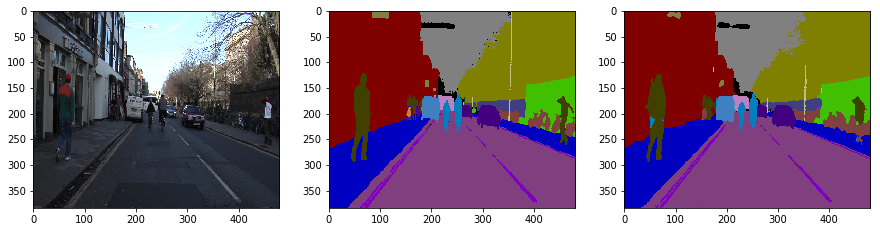

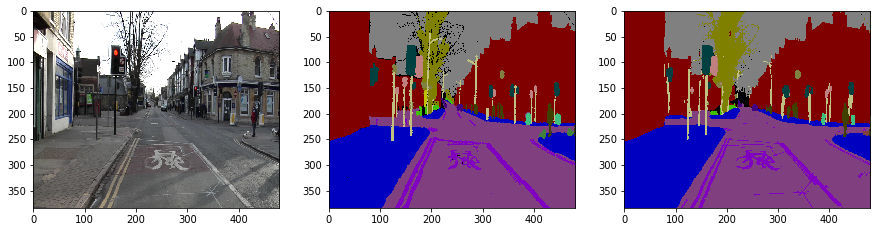

In [25]:
for i in range(images.shape[0]):
    image = unnormalize_image(images[i])    
    y_true = labels[i].reshape((image.shape[0],image.shape[1]))
    y_true = color_label(y_true, label_colors)
    y_pred = predicted_labels[i].reshape((image.shape[0],image.shape[1]))
    y_pred = color_label(y_pred, label_colors)
    show_image_row([image, y_true, y_pred])
    plt.show()        